# Tentative Results

## Configurations

- Test System: HP (2x Intel E5-2630 v2 @ 2.6GHz, 24 vCPUs, 64GB DDR3)
- SDD drive under test: 256GB - TOSHIBA THNSNJ256G8NU (S/N: 55MS101IT9JW)
- Filesystem: XFS
- RocksDB: 16B key size, 4KB value size
- RocksDB version: 5.14.3
- YCSB version: https://github.com/ljishen/YCSB @ d4168eb77c53e30b3792b9cff4bbb9be3818b510
- Maven version: 3.5.4
- Java version: 1.8.0_181, Oracle Corporation
- System info: Ubuntu 16.04.5 LTS, Linux pl2 4.4.132-0404132-generic #201805211041 SMP Mon May 21 10:42:56 UTC 2018 x86_64 x86_64 x86_64 GNU/Linux

#### FileSystem Information

```
$ xfs_info  /mnt/sdc1
meta-data=/dev/sdc1              isize=512    agcount=4, agsize=15626646 blks
         =                       sectsz=512   attr=2, projid32bit=1
         =                       crc=1        finobt=1 spinodes=0
data     =                       bsize=4096   blocks=62506582, imaxpct=25
         =                       sunit=0      swidth=0 blks
naming   =version 2              bsize=4096   ascii-ci=0 ftype=1
log      =internal               bsize=4096   blocks=30520, version=2
         =                       sectsz=512   sunit=0 blks, lazy-count=1
realtime =none                   extsz=4096   blocks=0, rtextents=0
```

Note that the sector size is 512 bytes.

In [1]:
import glob
import os
import re

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator


_SUFFIX = 'suf'
_VALUES = 'vals'

_BEFORE = 'before'
_AFTER = 'after'

SECTOR_SIZE_KB = 0.5


def __get_stats_diffs(file_prefix):
    stat2vals = {
        _BEFORE: {_SUFFIX: '_b.log', _VALUES: []},
        _AFTER:  {_SUFFIX: '_a.log', _VALUES: []}
    }

    for key, kv in stat2vals.items():
        with open(file_prefix + kv[_SUFFIX], 'r') as fh:
            content = fh.readlines()[-1]
            comps = content.split()
            for i in range(3, len(comps)):
                stat2vals[key][_VALUES].append(int(comps[i]))

    diffs = []
    for i in range(len(stat2vals[_BEFORE][_VALUES])):
        diffs.append(stat2vals[_AFTER][_VALUES][i] - stat2vals[_BEFORE][_VALUES][i])
    return diffs


def __get_runtime_sec_and_throughput(trans_file):
    with open(trans_file, 'r') as fh:
        runtime = 0
        throughput = 0
        for line in fh:
            if 'RunTime' in line:
                # the `Runtime` value is in ms
                runtime = int(re.split(', *', line)[2]) / 1000
            elif 'Throughput(ops/sec)' in line:
                throughput = float(re.split(', *', line)[2])
                break

    return runtime, throughput


def __get_stats(dir, round):
    device_stats_file_prefix = dir + '/device_stats_round' + str(round)
    transactions_file = dir + '/transactions_round' + str(round) + '.dat'

    runtime, ycsb_throughput = __get_runtime_sec_and_throughput(transactions_file)
    diffs = __get_stats_diffs(device_stats_file_prefix)

    # device IOPS, device MB/s, YCSB ops/sec
    return (diffs[0] + diffs[4]) / runtime, \
            (diffs[2] + diffs[6]) * SECTOR_SIZE_KB / 1024 / runtime, \
            ycsb_throughput

MEASUREMENT_WINDOW_SIZE = 3

def __get_rounds_in_ss_window(dir):
    profiles = glob.glob(dir + '/transactions_round[0-9]*.dat')

    if len(profiles) < MEASUREMENT_WINDOW_SIZE:
        raise RuntimeError(
            'Not enough transaction profiles in ' + dir)

    rounds = []
    for profile in profiles:
        rounds.append(int(re.search(r'round(\d+)', profile).group(1)))

    return sorted(rounds)[-MEASUREMENT_WINDOW_SIZE:]


from os.path import basename


def __get_threadcount(dir):
    return int(basename(dir).split('_')[0])


_DEVICE_IOPS = 'device_iops'
_DEVICE_THROUGHPUT = 'device_throughput'
_YCSB_THROUGHPUT = 'ycsb_throughput'

_MEAN = 'mean'
_STD = 'std'


def __get_avg_throughputs(dir):
    rounds = __get_rounds_in_ss_window(dir)

    device_iopses = []
    device_throughputs = []
    ycsb_throughputs = []

    for r in rounds:
        device_iops, device_throughput, ycsb_throughput = __get_stats(dir, r)
        device_iopses.append(device_iops)
        device_throughputs.append(device_throughput)
        ycsb_throughputs.append(ycsb_throughput)

    return __get_threadcount(dir), \
            {
                _DEVICE_IOPS:       {
                    _MEAN: np.mean(device_iopses),
                    _STD:  np.std(device_iopses, ddof=1)  
                },
                _DEVICE_THROUGHPUT: {
                    _MEAN: np.mean(device_throughputs),
                    _STD:  np.std(device_throughputs, ddof=1)
                },
                _YCSB_THROUGHPUT:   {
                    _MEAN: np.mean(ycsb_throughputs),
                    _STD:  np.std(ycsb_throughputs, ddof=1)
                }
            }


def __list_subfolders(folder):
    path = '../data/ycsb/' + folder
    files = []
    for file in os.listdir(path):
        if re.match(r'\d+_threads', file):
            files.append(path + '/' + file)
    return files


def plot_throughputs(folder):
    plt.rc('xtick',labelsize=8)
    plt.rc('ytick',labelsize=8)

    fig, ax = plt.subplots()
    fig.set_dpi(150)

    tc2th = {}
    subfolders = __list_subfolders(folder)
    for subf in subfolders:
        threadcount, throughputs = __get_avg_throughputs(subf)
        tc2th[threadcount] = throughputs

    tcs = sorted(tc2th.keys())
    ths = []
    for tc in tcs:
        ths.append(tc2th[tc])

    max_key = max(tc2th.keys(), key=(lambda key: tc2th[key][_YCSB_THROUGHPUT][_MEAN]))
    print('Info of the max YCSB throughput: ' + str(max_key) + ' threads -> ' + str(tc2th[max_key]))

    bars = []

    color='b'
    means = [v[_YCSB_THROUGHPUT][_MEAN] for v in ths]
    bars.append(ax.errorbar(tcs, means,
                              yerr=[v[_YCSB_THROUGHPUT][_STD] for v in ths],
                              fmt='-.x', color=color))
    for idx, tc in enumerate(tcs):
        ax.text(tc, means[idx] - 260, '%.1f' % means[idx],
                ha='center', size=6, color=color)
    ax.set_ylabel('ops/sec', color=color)
    ax.tick_params('y', colors=color)
    ax.set_ylim(0)
    
    ax.grid(which='major', alpha=0.5)

    ax_t = ax.twinx()

    color='r'
    means = [v[_DEVICE_THROUGHPUT][_MEAN] for v in ths]
    bars.append(ax_t.errorbar(tcs, means,
                            yerr=[v[_DEVICE_THROUGHPUT][_STD] for v in ths],
                            fmt='-x', color=color))
    for idx, tc in enumerate(tcs):
        ax_t.text(tc, means[idx] + 4, '%.1f' % means[idx],
                  ha='center', size=6, color=color)
    ax_t.set_ylabel('MB/s', color=color)
    ax_t.tick_params('y', colors=color)
    ax_t.set_ylim(0)

    ax.set_xlabel('number of threads')

    plt.xticks(tcs)
    plt.title('Device Throughput and YCSB Throughput\n(%s)' % folder, y=1.12)

    plt.legend(bars, ['YCSB throughput', 'device throughput'],
               loc=8,
               bbox_to_anchor=(0.5, 1),
               ncol=2)

    plt.show()

## workloadc

- Total 13081649 keys. The database dir size is 100.76 GB.
- [YCSB workload parameter file](https://github.com/ljishen/ycsb-rocksdb/blob/master/analysis/data/workloadc/workloadc_21/myworkloadc), inherited from the [read only workloadc](https://github.com/ljishen/YCSB/wiki/Core-Workloads), read 75% (~75GB) of the data set size

## Distribution of the Sizes of Block Requests (aggregation over 5 rounds)

```txt
SECTOR_SIZE   RW   COUNT         RATIO (in R/W)   RATIO (Overall)
----------------------------------------------------------------------
24            R    13294511             71.558%           71.557%
16            R    4565327              24.573%           24.573%
8             R    571794                3.078%            3.078%
32            R    130809                0.704%            0.704%
256           R    15227                 0.082%            0.082%
240           R    177                   0.001%            0.001%
248           R    143                   0.001%            0.001%
0             W    104                  37.818%            0.001%
232           R    85                    0.000%            0.000%
128           R    70                    0.000%            0.000%
224           R    63                    0.000%            0.000%
208           R    54                    0.000%            0.000%
104           R    51                    0.000%            0.000%
8             W    41                   14.909%            0.000%
216           R    41                    0.000%            0.000%
136           R    33                    0.000%            0.000%
144           R    29                    0.000%            0.000%
32            W    28                   10.182%            0.000%
200           R    28                    0.000%            0.000%
160           R    24                    0.000%            0.000%
2             W    23                    8.364%            0.000%
176           R    23                    0.000%            0.000%
120           R    21                    0.000%            0.000%
168           R    19                    0.000%            0.000%
16            W    17                    6.182%            0.000%
112           R    17                    0.000%            0.000%
1             W    16                    5.818%            0.000%
152           R    15                    0.000%            0.000%
88            R    14                    0.000%            0.000%
40            R    14                    0.000%            0.000%
1             R    12                    0.000%            0.000%
192           R    12                    0.000%            0.000%
64            R    9                     0.000%            0.000%
0             R    9                     0.000%            0.000%
17            W    8                     2.909%            0.000%
15            W    8                     2.909%            0.000%
184           R    7                     0.000%            0.000%
64            W    6                     2.182%            0.000%
48            W    5                     1.818%            0.000%
40            W    5                     1.818%            0.000%
5             W    4                     1.455%            0.000%
56            R    4                     0.000%            0.000%
48            R    4                     0.000%            0.000%
13            W    4                     1.455%            0.000%
12            W    3                     1.091%            0.000%
18            W    1                     0.364%            0.000%
14            W    1                     0.364%            0.000%
10            W    1                     0.364%            0.000%
...

SUMMARY (512-byte sectors)
----------------------------------------------------------------------
Total read I/Os : 18578646       [ 99.999%]
Total write I/Os: 275            [  0.001%]
Total read sectors : 404956412   [ 99.999%,  197732.623MB]
Total write sectors: 2788        [  0.001%,       1.361MB]
```

## System Memory

Memory is almost filled up with page cache

```
$ free -mh
              total        used        free      shared  buff/cache   available
Mem:            62G        3.5G        1.6G         60M         57G         58G
Swap:          974M        967M        7.8M
```

## System CPU

~50% of iowait on average, which means the CPUs are far from saturated. 

Info of the max YCSB throughput: 21 threads -> {'device_iops': {'mean': 26945.37892256233, 'std': 125.40153875667552}, 'device_throughput': {'mean': 287.11740566387067, 'std': 1.3446418500549819}, 'ycsb_throughput': {'mean': 67524.343059954132, 'std': 312.79844835667353}}


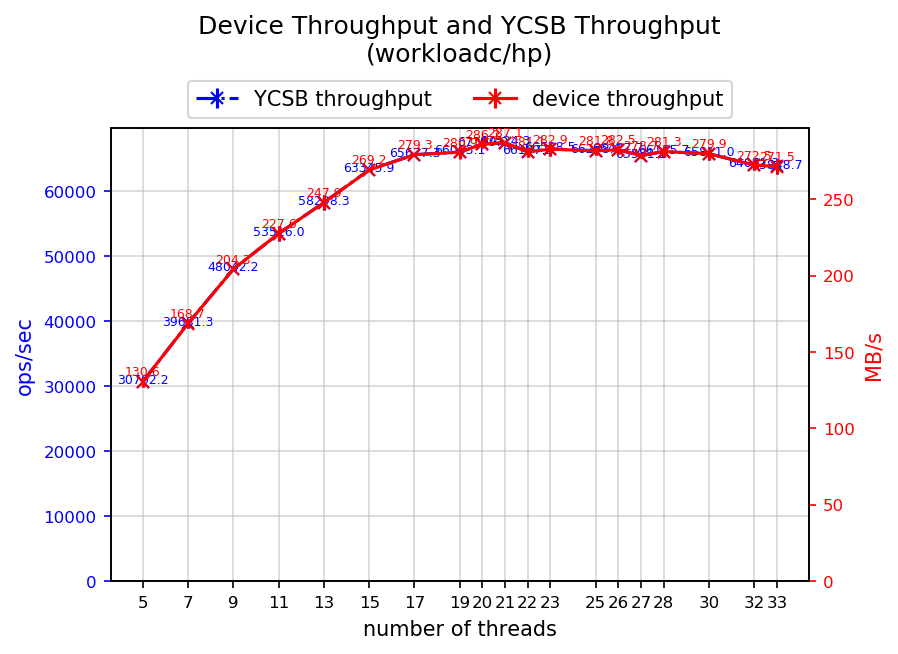

In [2]:
plot_throughputs('workloadc/hp')

According to the [baseline IOPS performance](https://github.com/ljishen/SSSPT/blob/master/analysis/notebooks/conclusion.ipynb) of this drive, we use degree of 5 to generate the fitting polynomial:

In [3]:
x = [0.5, 4, 8, 16, 32, 64, 128, 1024]
_y = [38345.034, 37472.950, 34949.841, 21339.819, 11550.429, 6065.414, 3162.433, 416.407]
y = []

print('\n== Raw Throughputs ==')
for idx, val in enumerate(x):
    y.append(val * _y[idx] / 1024)
    print(str(val) + ' KB\t->\t' + str(y[-1]) + ' MB/s')

z = np.polyfit(x, y, 6)
p = np.poly1d(z)

print('\n== Estimated Throughputs ==')
for val in x:
    print(str(val) + ' KB\t->\t' + str(p(val)) + ' MB/s')

avg_throughput = p(12) * 0.71558 + p(8) * 0.24573

print('\nThe estimated throughput for the mix block sizes is %f MB/s' % avg_throughput)


== Raw Throughputs ==
0.5 KB	->	18.7231611328125 MB/s
4 KB	->	146.3787109375 MB/s
8 KB	->	273.0456328125 MB/s
16 KB	->	333.434671875 MB/s
32 KB	->	360.95090625 MB/s
64 KB	->	379.088375 MB/s
128 KB	->	395.304125 MB/s
1024 KB	->	416.407 MB/s

== Estimated Throughputs ==
0.5 KB	->	14.1635108668 MB/s
4 KB	->	159.944169245 MB/s
8 KB	->	260.731908679 MB/s
16 KB	->	337.188135378 MB/s
32 KB	->	360.48172347 MB/s
64 KB	->	379.112425368 MB/s
128 KB	->	395.303711081 MB/s
1024 KB	->	416.407005112 MB/s

The estimated throughput for the mix block sizes is 288.513041 MB/s


The throughput in the test (287.09 MB/s) is close to the number we calculated above, meaning the test has reached the upper limit of theoretical throughput.

In [4]:
print('The average IO ratio (device_iops / ycsb_ops) is ' + str(26942.213511605914 / 67517.369925388659))
print('The average throughput ratio (device_mbs / ycsb_mbs) is ' + \
      str(287.09412468262587 / (67517.369925388659 * (8192 + 16) / 1024 / 1024)))

The average IO ratio (device_iops / ycsb_ops) is 0.3990412177100339
The average throughput ratio (device_mbs / ycsb_mbs) is 0.5432144998857762


## workloada

- Total 2611239 keys.
- [YCSB workload parameter file](https://github.com/ljishen/ycsb-rocksdb/blob/master/analysis/data/ycsb/workloada/workloada_4/myworkloada), inherited from the [update heavy workloada](https://github.com/ljishen/YCSB/wiki/Core-Workloads). It has a mix of 50/50 reads and updates that operate on all over the keys.

## Distribution of the Sizes of Block Requests

```txt
SECTOR_SIZE   RW   COUNT         RATIO (in R/W)   RATIO (Overall)
----------------------------------------------------------------------
24            R    359785               53.171%           46.160%
16            R    136926               20.236%           17.568%
1024          W    73494                71.517%            9.429%
8             R    65708                 9.711%            8.430%
256           R    19511                 2.883%            2.503%
40            R    15037                 2.222%            1.929%
8             W    14031                13.653%            1.800%
32            R    12966                 1.916%            1.664%
1016          W    11097                10.798%            1.424%
56            R    10255                 1.516%            1.316%
72            R    7292                  1.078%            0.936%
88            R    5474                  0.809%            0.702%
64            R    4195                  0.620%            0.538%
48            R    4148                  0.613%            0.532%
104           R    4086                  0.604%            0.524%
120           R    3174                  0.469%            0.407%
80            R    2658                  0.393%            0.341%
136           R    2464                  0.364%            0.316%
0             W    2310                  2.248%            0.296%
96            R    2203                  0.326%            0.283%
128           R    2006                  0.296%            0.257%
152           R    1980                  0.293%            0.254%
112           R    1892                  0.280%            0.243%
168           R    1597                  0.236%            0.205%
144           R    1424                  0.210%            0.183%
184           R    1324                  0.196%            0.170%
160           R    1218                  0.180%            0.156%
216           R    1108                  0.164%            0.142%
176           R    1107                  0.164%            0.142%
200           R    1105                  0.163%            0.142%
192           R    1033                  0.153%            0.133%
240           R    904                   0.134%            0.116%
208           R    843                   0.125%            0.108%
224           R    765                   0.113%            0.098%
232           R    758                   0.112%            0.097%
248           R    630                   0.093%            0.081%
512           R    263                   0.039%            0.034%
472           W    169                   0.164%            0.022%
464           W    139                   0.135%            0.018%
31            W    110                   0.107%            0.014%
29            W    77                    0.075%            0.010%
13            W    77                    0.075%            0.010%
64            W    76                    0.074%            0.010%
264           R    63                    0.009%            0.008%
3             W    61                    0.059%            0.008%
26            W    61                    0.059%            0.008%
280           R    57                    0.008%            0.007%
296           R    56                    0.008%            0.007%
30            W    47                    0.046%            0.006%
...

SUMMARY (512-byte sectors)
----------------------------------------------------------------------
Total read I/Os : 676660         [ 86.815%]
Total write I/Os: 102765         [ 13.185%]
Total read sectors : 24823885    [ 22.169%,   12121.038MB]
Total write sectors: 87151123    [ 77.831%,   42554.259MB]
```

Info of the max YCSB throughput: 20 threads -> {'device_iops': {'mean': 2537.6979601991784, 'std': 160.58575551758767}, 'device_throughput': {'mean': 153.47003804424494, 'std': 4.7924165195252977}, 'ycsb_throughput': {'mean': 5368.2069284726849, 'std': 413.38332492791397}}


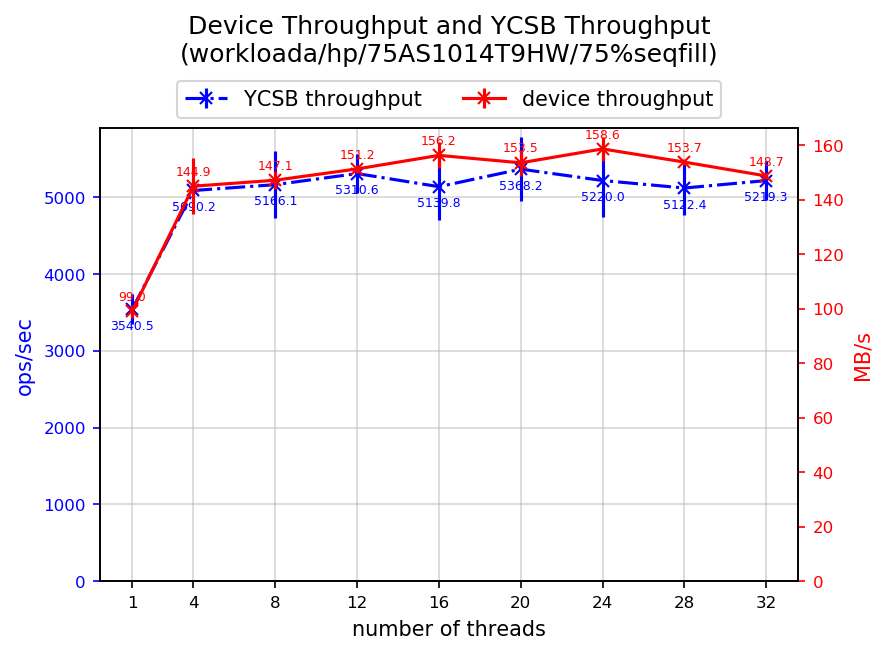

In [5]:
plot_throughputs('workloada/hp/75AS1014T9HW/75%seqfill')

Info of the max YCSB throughput: 8 threads -> {'device_iops': {'mean': 4480.9667674288858, 'std': 13.206649324071673}, 'device_throughput': {'mean': 137.77552652057997, 'std': 0.50189081965760074}, 'ycsb_throughput': {'mean': 3518.8156160540761, 'std': 27.53140902107004}}


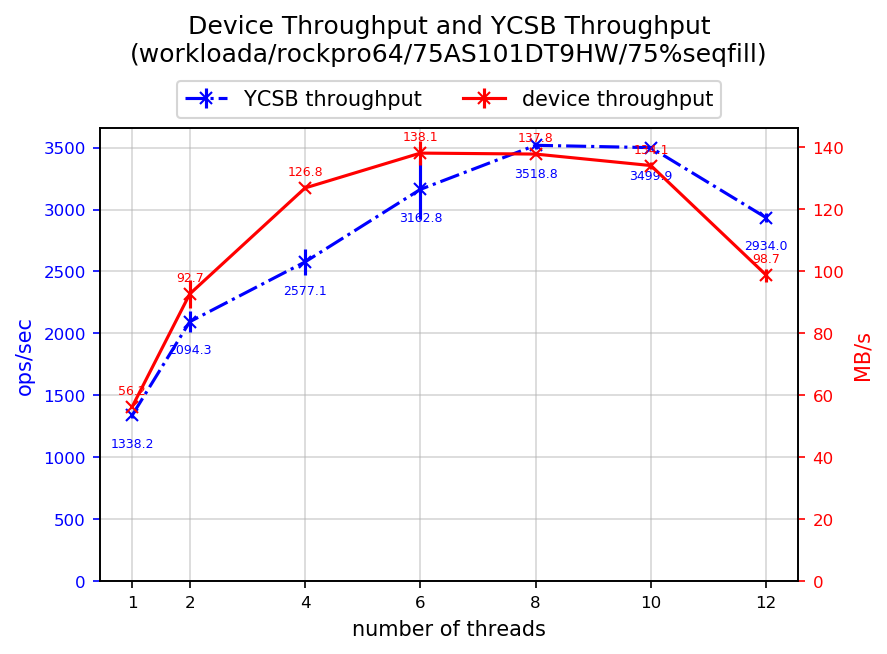

In [6]:
plot_throughputs('workloada/rockpro64/75AS101DT9HW/75%seqfill')

Info of the max YCSB throughput: 20 threads -> {'device_iops': {'mean': 1063.6889665697784, 'std': 77.135211066864741}, 'device_throughput': {'mean': 75.325136504404213, 'std': 6.1477357379253821}, 'ycsb_throughput': {'mean': 4007.1727019705381, 'std': 304.15665349134713}}


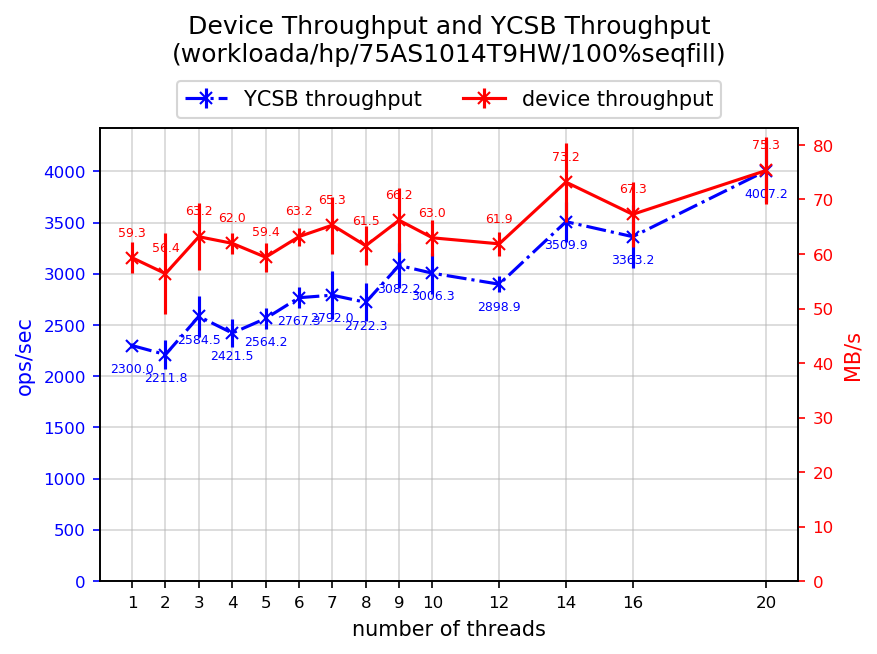

In [7]:
plot_throughputs('workloada/hp/75AS1014T9HW/100%seqfill')